In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pickle
import tensorflow.keras.backend as K
from tqdm import tqdm

from model import TBPP384
from tbpp_data import InputGenerator
from tbpp_training import TBPPFocalLoss
from tbpp_metric import fscore
from tbpp_metric import evaluate_polygonal_results
from utils.model import load_weights
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3
from utils.training import Logger
from utils.vis import plot_box

### Data

In [3]:
from data_cocotext import GTUtility
gt_util = GTUtility('data/COCO-Text', polygon=True)

gt_util_train, gt_util_val = gt_util.split(0.9)

### Model

In [4]:
# TextBoxes++
model = TBPP384(softmax=False)
weights_path = './checkpoints/201911160931_tbpp384fl_COCOtext/weights.199.h5'
confidence_threshold = 0.3
plot_name = 'tbpp384fl_cocotext'

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
load_weights(model, weights_path)
checkdir = os.path.dirname(weights_path)

from tbpp_prior import PriorUtil
prior_util = PriorUtil(model)

### Prediction

In [6]:
_, inputs, images, data = gt_util_val.sample_random_batch(1024)

preds = model.predict(inputs, batch_size=1, verbose=1)

1024/1024 [==============================] - 22s 22ms/sample


In [7]:
preds.shape

(1024, 43120, 19)

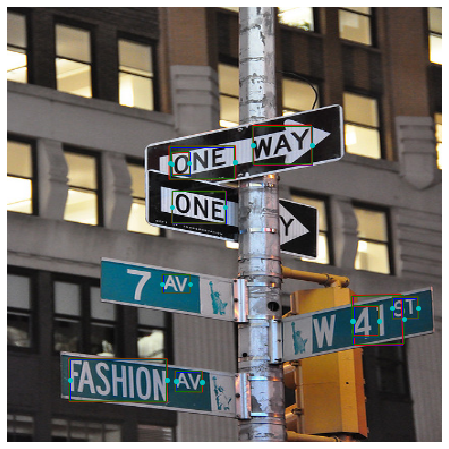

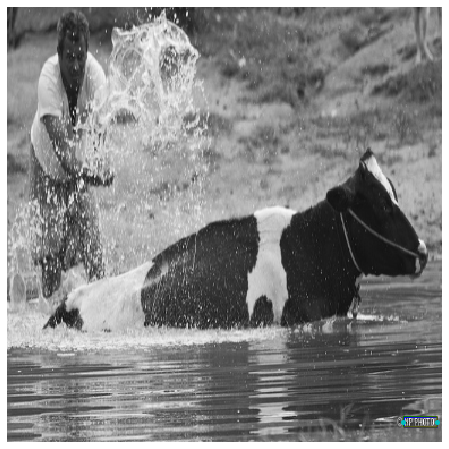

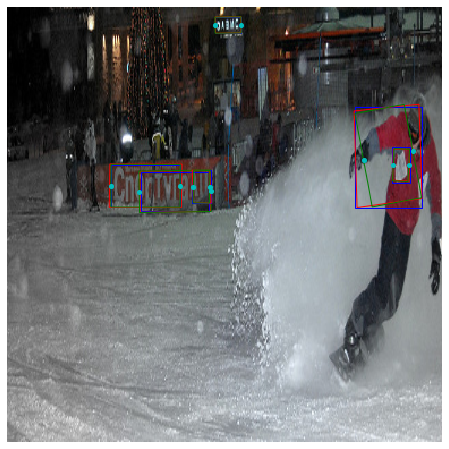

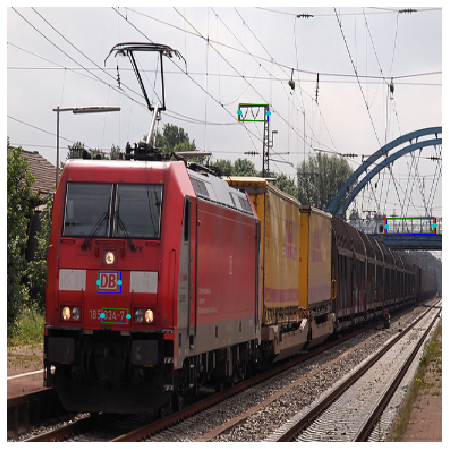

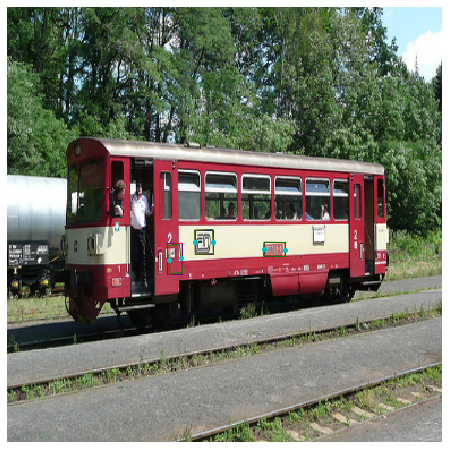

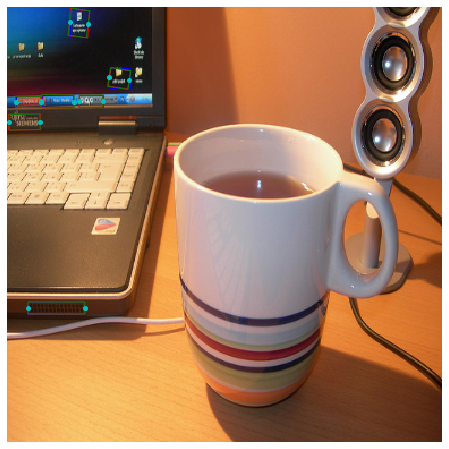

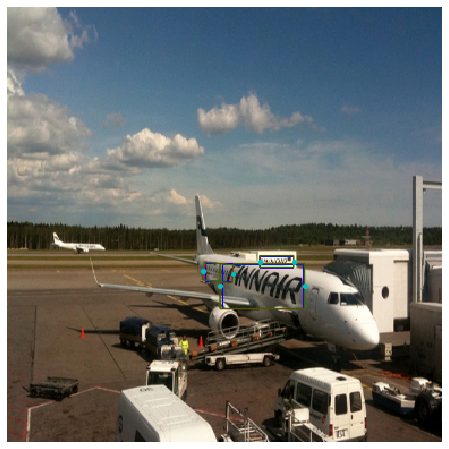

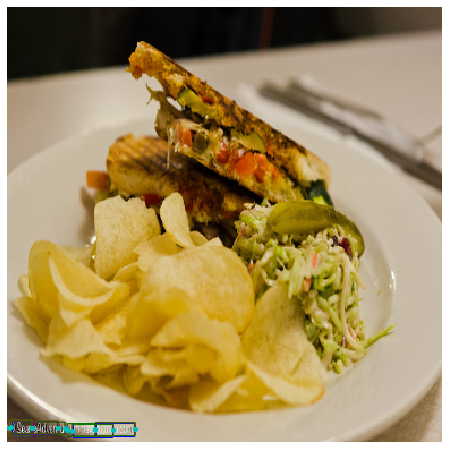

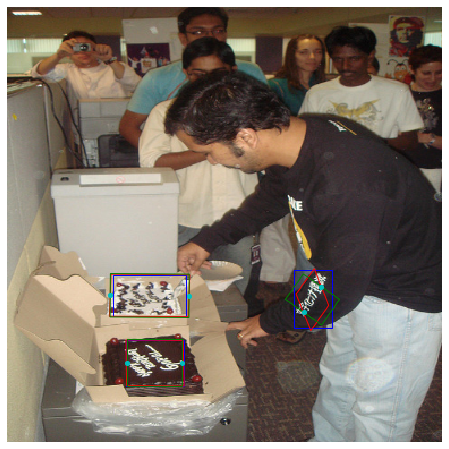

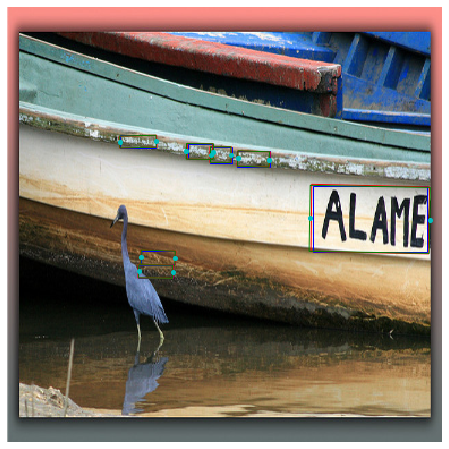

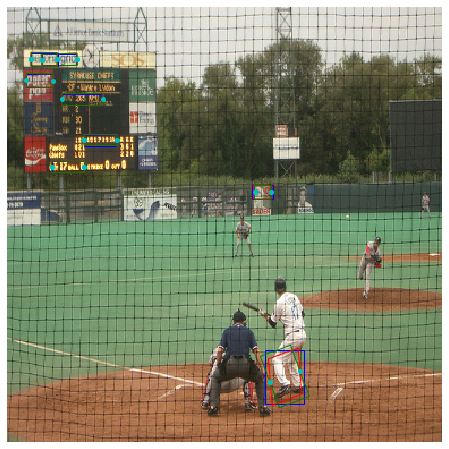

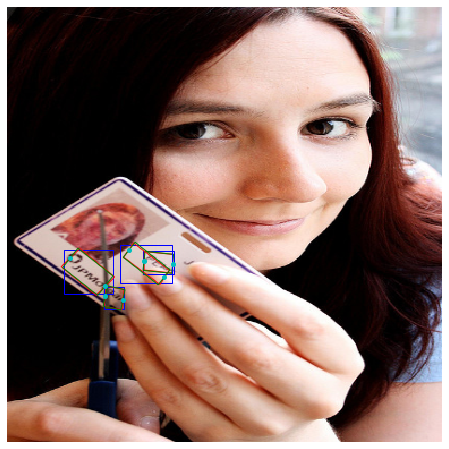

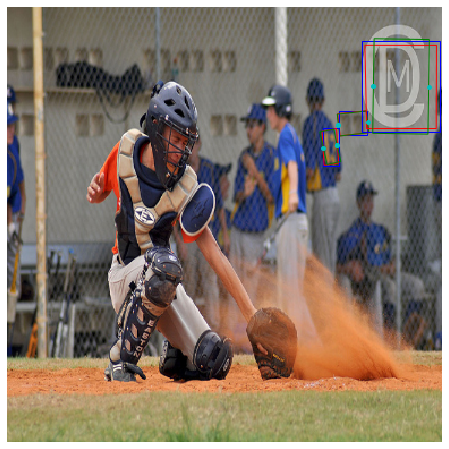

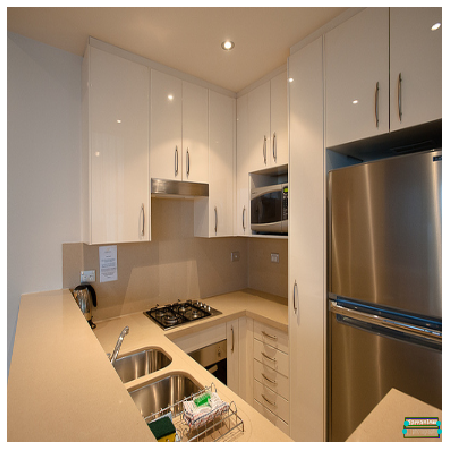

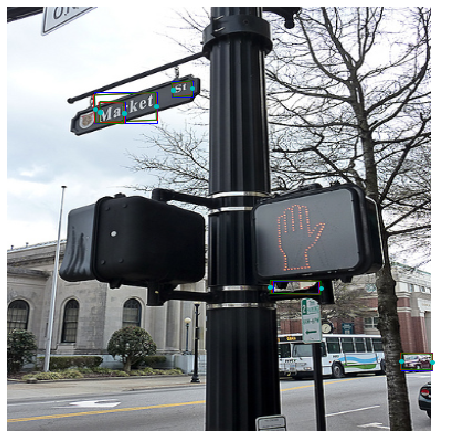

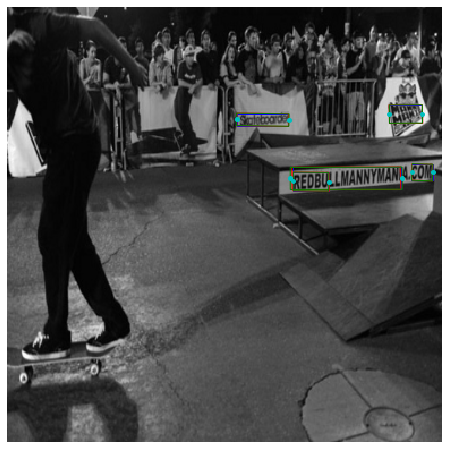

In [8]:
for i in range(16):
    res = prior_util.decode(preds[i], confidence_threshold, fast_nms=False)
    bbox = res[:,0:4]
    quad = res[:,4:12]
    rbox = res[:,12:17]
    #print(bbox)
    
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    ax = plt.gca()
    for j in range(len(bbox)):
        #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
        plot_box(bbox[j]*384, box_format='xyxy', color='b')
        plot_box(np.reshape(quad[j],(-1,2))*384, box_format='polygon', color='r')
        plot_box(rbox3_to_polygon(rbox[j])*384, box_format='polygon', color='g')
        plt.plot(rbox[j,[0,2]]*384, rbox[j,[1,3]]*384, 'oc', markersize=4)
    #prior_util.plot_gt()
    #prior_util.plot_results(res)
    plt.axis('off')
    plt.show()

### Grid Search

In [9]:
steps = np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in data], [d[:,4:12] for d in results])
    recall = TP / (TP+FN)
    precision = TP / (TP+FP)
    fmes = fscore(precision, recall)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))

threshold 0.05 f-measure 0.05
threshold 0.10 f-measure 0.13
threshold 0.15 f-measure 0.21
threshold 0.20 f-measure 0.27
threshold 0.25 f-measure 0.31
threshold 0.30 f-measure 0.34
threshold 0.35 f-measure 0.36
threshold 0.40 f-measure 0.36
threshold 0.45 f-measure 0.35
threshold 0.50 f-measure 0.33
threshold 0.55 f-measure 0.30
threshold 0.60 f-measure 0.25
threshold 0.65 f-measure 0.20
threshold 0.70 f-measure 0.15
threshold 0.75 f-measure 0.10
threshold 0.80 f-measure 0.07
threshold 0.85 f-measure 0.06
threshold 0.90 f-measure 0.03
threshold 0.95 f-measure 0.01


0.4 0.3643248889562731


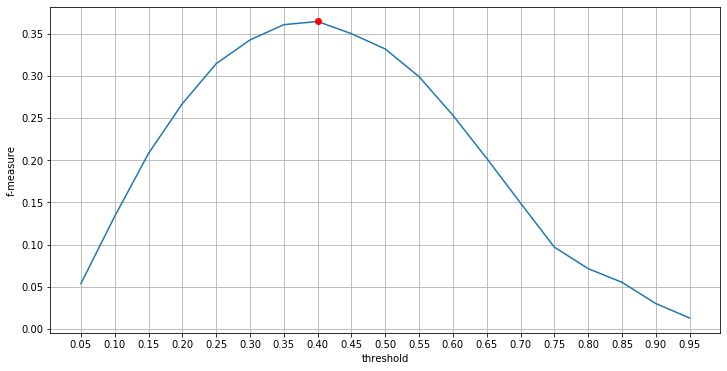

In [10]:
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()

### Precisions, Recall, F-measue

In [ ]:
batch_size = 32
confidence_threshold = 0.4

max_samples = gt_util_val.num_samples
max_samples = batch_size * 32

test_gt = []
test_results = [] 

for i in tqdm(range(int(np.ceil(max_samples/batch_size)))):
    inputs, data = gt_util_val.sample_batch(batch_size, i)
    preds = model.predict(inputs, batch_size, verbose=0)
    res = [prior_util.decode(p, confidence_threshold) for p in preds]
    test_gt.extend(data)
    test_results.extend(res)

TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in test_gt], [d[:,4:12] for d in test_results])
recall = TP / (TP+FN)
precision = TP / (TP+FP)
fmes = fscore(precision, recall)

print('samples train     %i' % (gt_util_train.num_samples))
print('samples val       %i' % (gt_util_val.num_samples))

print('samples           %i' % (max_samples))
print('threshold         %0.3f' % (confidence_threshold))
print('precision         %0.3f' % (precision))
print('recall            %0.3f' % (recall))
print('f-measure         %0.3f' % (fmes))

trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('trainable parameters     %10i' %(trainable_count))
print('non-trainable parameters %10i' %(non_trainable_count))

 31%|███▏      | 10/32 [00:06<00:13,  1.57it/s]